In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import allantools as at

# Loading data

Xiaoke has collected 2 sets of data using the actual MEMS @ 10 kHz for 2 min.  
- quiet enviromnent
- noisy environment

In [209]:
quietdata = pd.read_table("mems0508/FPGA1.txt", names=["FPGA"])[1::]
quietdata["USB"] = pd.read_table("mems0508/USB1.txt", names=["USB"])["USB"][1::]
quietdata=quietdata.astype(float)

noisydata = pd.read_table("mems0508/FPGA2.txt", names=["FPGA"])[1::]
noisydata["USB"] = pd.read_table("mems0508/USB2.txt", names=["USB"])["USB"][1::]
noisydata=noisydata.astype(float)

C:\Users\X\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(0.5, 1.0, 'Noisy')

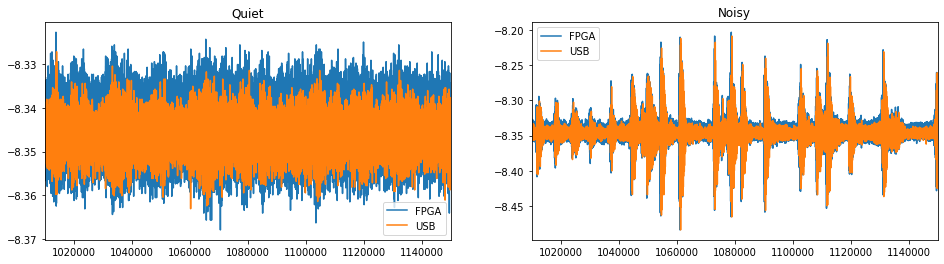

In [210]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
quietdata[-190000:-50000].plot(ax=ax[0])
ax[0].set_title("Quiet")
noisydata[-190000:-50000].plot(ax=ax[1])
ax[1].set_title("Noisy")

Text(0.5, 1.0, 'Noisy')

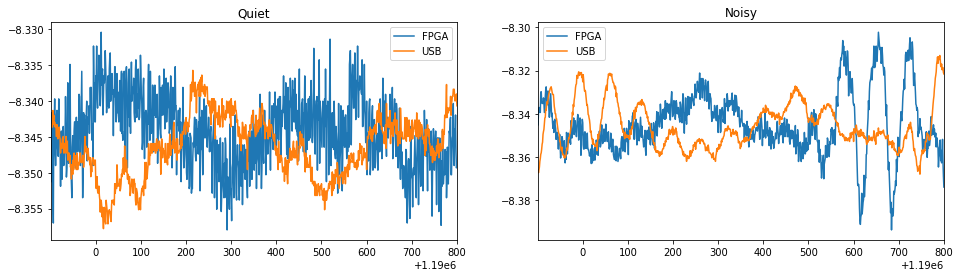

In [211]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
quietdata[-10100:-9200].plot(ax=ax[0])
ax[0].set_title("Quiet")
noisydata[-10100:-9200].plot(ax=ax[1])
ax[1].set_title("Noisy")

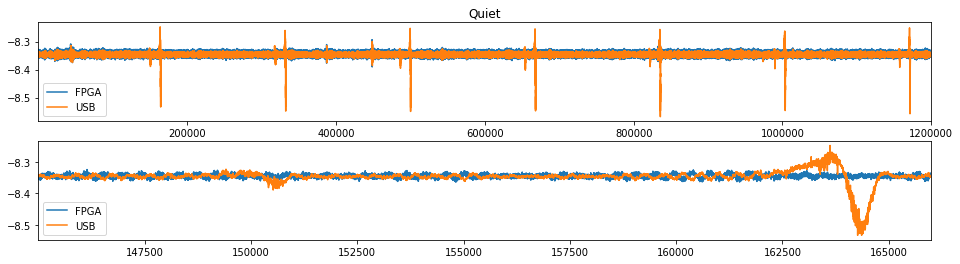

In [212]:
fig, ax = plt.subplots(nrows=2, figsize=(16,4))
quietdata.plot(ax=ax[0])
ax[0].set_title("Quiet")
quietdata[145000:166000].plot(ax=ax[1])

# What I want

Figure out:
1. contribution of the offset noise to the interferomter
2. introducing the time gap where the vibration data is missing and find the limitation of the FPGA

The finding of these will tell us what we can expect using FPGA, which can be used to develop a better scheme on bias/scaling factor correction.

# 1. Offset  noise

## 1.1 Approach

I define USB as my reference. I convert everything in the unit of $\Delta \Phi$ using the sensitivity function and compare the data from there.

To address the time delay issue, I will shift FPGA forward and backward in time to look for the minimal noise.

To address the missing information at the end of the interferometer, I need to integrate a function into the sensitivity function for this.

I uderstand that this is giving the noise difference between USB and FPGA and not between FPGA and MEMS. However, there is no reason that MEMS doesn't drift equally like USB card.  
--> I think it is a good approximation.

## 1.2 Defining functions

In [213]:
# shifting only the FPGA data 
# for now let us only take a small sample size (5s) for faster development later
# later on we need [10000:1100000]
def shiftData(rawDF,shiftnr):
    tempdf=rawDF.copy()
    tempdf["FPGA"]=tempdf["FPGA"].shift(shiftnr)
    return tempdf.iloc[10000:800000]

# This function generates the sensitivity function 
# for the duration of a specified interferomter
# nIgnor is the number of data at the end set to 0 to simulate missing data issue.
def senFct(TT,sampRate,nIgnor):
    senFctData=[i if i<TT/2 else TT-i for i in np.linspace(0,TT,int(TT*sampRate))]
    if nIgnor==0:
        pass
    else:
        senFctData[-nIgnor:]=[0 for i in range(nIgnor)]
    return senFctData

## 1.3 Offset RMSE and standard deviation in $\Delta \Phi$ - no missing data
Before loop over let us look at the 0 delay for data testing.

In [214]:
quietdata=quietdata[-190000:-50000]
noisydata=noisydata[-190000:-50000]

In [248]:
data_shifted = [shiftData(dataset,int(0.0212*10000)) for dataset in [quietdata, noisydata]]

In [249]:
senFct20=senFct(0.02,10000,0)
nrDataInter = len(senFct20)
nrMeasurement = int(len(data_shifted[0])/nrDataInter)
senFct20Data = np.concatenate([senFct20 for i in range(nrMeasurement)])

In [250]:
for i in range(2):
    data_shifted[i]["SensFct"]=senFct20Data

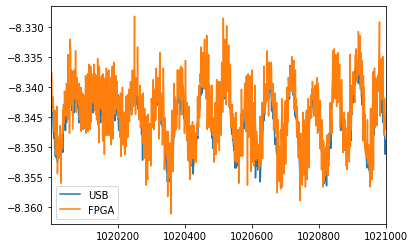

In [251]:
data_shifted[0].iloc[0:1000][["USB","FPGA"]].plot()

Now the dataframes have all we need.

Now let us get the $\Delta\Phi$ from FPGA and USB by chopping the data into 20ms interferometers.

In [252]:
usbPhase=[[],[]]
fpgaPhase=[[],[]]
for ind, dataset in enumerate(data_shifted):
    for i in range(nrMeasurement):
        fpgaPhase[ind].append((dataset["FPGA"]*dataset["SensFct"]).iloc[i*nrDataInter:(i+1)*nrDataInter].mean())
        usbPhase[ind].append((dataset["USB"]*dataset["SensFct"]).iloc[i*nrDataInter:(i+1)*nrDataInter].mean())
usbPhase=np.array(usbPhase)
fpgaPhase=np.array(fpgaPhase)

Quiet data

Text(0.5, 1.0, 'Interferometer phase difference')

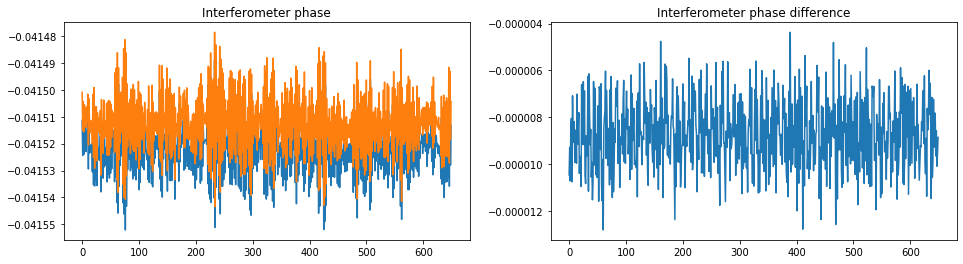

In [253]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].plot(usbPhase[0])
ax[0].plot(fpgaPhase[0])
ax[1].plot(usbPhase[0]-fpgaPhase[0])
ax[0].set_title("Interferometer phase")
ax[1].set_title("Interferometer phase difference")

Noisy data

Text(0.5, 1.0, 'Interferometer phase difference')

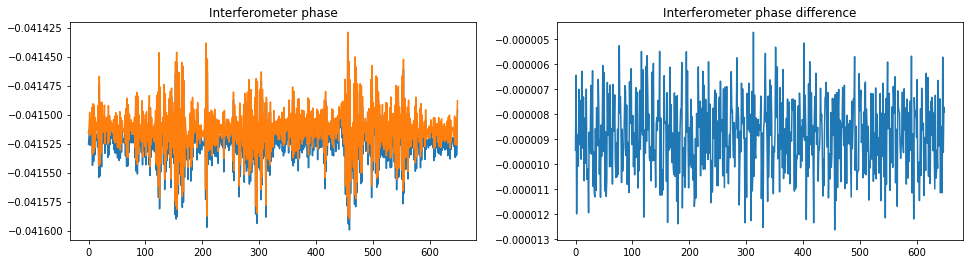

In [254]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].plot(usbPhase[1])
ax[0].plot(fpgaPhase[1])
ax[1].plot(usbPhase[1]-fpgaPhase[1])
ax[0].set_title("Interferometer phase")
ax[1].set_title("Interferometer phase difference")

As we can see here, the offset varies a bit. I use the std of the phase difference as the stability of the offset for the following validation. As we will be interested in the shot to shot noise.

Bear in mind, we dont worry about DC component of the phase difference, but the variation!  

Calibrating the offset will change the DC component but the variation stays the same!

However, we use MSE to optimise the time delay and RMS for intereromter estimation. (danger: MSE is offset dependent...)

The MSE error (considers the offset) we get are:

In [255]:
msesqQ=np.sqrt(np.mean((usbPhase[0]-fpgaPhase[0])**2))
rel_msesqQ=msesqQ/(usbPhase[0].mean())
msesqN=np.sqrt(np.mean((usbPhase[1]-fpgaPhase[1])**2))
rel_msesqN=msesqN/(usbPhase[1].mean())

print("Quiet environment MSE error: "+ str(format(msesqQ, '.2g')))
print("Relative error compare to the input: "+ str(format(rel_msesqQ, '.2g')))

print("Noisy environment MSE error: "+ str(format(msesqN, '.2g')))
print("Relative error compare to the input: "+ str(format(rel_msesqN, '.2g')))

Quiet environment MSE error: 8.9e-06
Relative error compare to the input: -0.00021
Noisy environment MSE error: 9e-06
Relative error compare to the input: -0.00022


RMS noise (ignoring the offset) are:

In [256]:
stdsqQ=np.std((usbPhase[0]-fpgaPhase[0]))
rel_stdsqQ=stdsqQ/(usbPhase[0].mean())
stdsqN=np.std((usbPhase[1]-fpgaPhase[1]))
rel_stdsqN=stdsqN/(usbPhase[1].mean())

print("Quiet environment RMS error: "+ str(format(stdsqQ, '.2g')))
print("Relative error compare to the input: "+ str(format(rel_stdsqQ, '.2g')))

print("Noisy environment RMS error: "+ str(format(stdsqN, '.2g')))
print("Relative error compare to the input: "+ str(format(rel_stdsqN, '.2g')))

Quiet environment RMS error: 1.5e-06
Relative error compare to the input: -3.7e-05
Noisy environment RMS error: 1.5e-06
Relative error compare to the input: -3.6e-05


### Comments

It is as expected the MSE error is larger due to offset. but we dont care about that, because we can add a constant value to the experiment. But the RMS tells us about the impact on the interferomter. 

This is a bit scary. The standard deviation of the offset variation over 5 s would be around 0.1-0.2% of the measurement.  

If we go one step futher and look in term of interferomter.

Given phase shifter's accuracy is $2\pi/400$, which we want to match with. The maximal acceleration we can allow us is ploted below:

In [155]:
# some global constants
keff = 4*np.pi/0.00000078
g=9.81
rel_offsetRMS = 0.00005

In [161]:
# phase shifter accuracy in g as a function interferometer TT
pshifter_acy = lambda TT: 2*np.pi/(g*keff*(TT/2)**2)/400
detnoise_acy4 = lambda TT: 2*np.pi/(g*keff*(TT/2)**2)/4
detnoise_acy10 = lambda TT: 2*np.pi/(g*keff*(TT/2)**2)/10
detnoise_acy50 = lambda TT: 2*np.pi/(g*keff*(TT/2)**2)/50

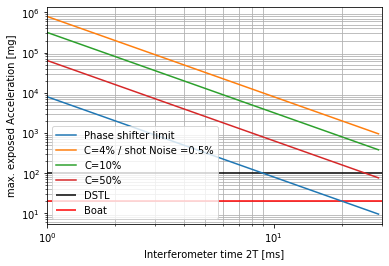

In [164]:
TTlist=np.arange(1,30)
maxAccelerationPS = 1000*np.array([pshifter_acy(TT*0.001)/rel_offsetRMS for TT in TTlist])
maxAccelerationDN4 = 1000*np.array([detnoise_acy4(TT*0.001)/rel_offsetRMS for TT in TTlist])
maxAccelerationDN10 = 1000*np.array([detnoise_acy10(TT*0.001)/rel_offsetRMS for TT in TTlist])
maxAccelerationDN50 = 1000*np.array([detnoise_acy50(TT*0.001)/rel_offsetRMS for TT in TTlist])
plt.loglog(TTlist, maxAccelerationPS)
plt.loglog(TTlist, maxAccelerationDN4)
plt.loglog(TTlist, maxAccelerationDN10)
plt.loglog(TTlist, maxAccelerationDN50)
plt.hlines(100,0,100, colors="black")
plt.hlines(20,0,100, colors="red")
plt.grid(which="minor")
plt.xlabel("Interferometer time 2T [ms]")
plt.ylabel("max. exposed Acceleration [mg]")
plt.xlim([1,30])
plt.legend(["Phase shifter limit","C=4% / shot Noise =0.5%","C=10%","C=50%","DSTL","Boat"])

- Black and red lines show the DSTL requirement and boat vibrations. 
- The blue line shows if we assume the Phase shifter to be the noise limitation. (Most sensitive case!)  

I forgot the take the detection/atom shot noise into considertaion.  
Without going too much more into calculation, I will take the parameters of the imperial one axis system:  
$\sigma_{P_2} = 0.005$  
I take the contrast to be 25% 
This means, we can roughly resolve a fringe spacing with a accuracy of $2\pi/50$ (or 120 mrad)

- Orange line shows the estimation using above assumptions. 

===================================

What these show, is:  
to operate on a boat and under realistic condition, we <font color="#ff0000"><b>can't</b></font> go beyong 2T=9ms.  
Any improvement on the contrast and shot noise will move the orange line towards the blue line and even lower the T time.  
Messing up condition, moves the orange line towards the right hand side of the graph, but will the FPGA correction worse.  
(<font color="#ff0000">This is what David B. was talking about!!!</font>)

Another way forward is to reduce the ratio between the offset noise and measurement signal (<font color="#ff0000"><b>0.002</b></font>).

## 1.4 Reduce Standard Dev of offset noise

How can we reduce the MSE offset noise:
- Time delay between USB and FPGA

To do this, we want to repeat above calculations just varying the shift parameter.  
Hence, let us pack above calculation into a function:

(I use the first 0.5 s of the data to calibrate the offset to improve the RMSE)

In [148]:
?shiftData

In [149]:
def getNoise(dataQ, dataN, shiftNr):
    data_shifted = [shiftData(dataset,shiftNr) for dataset in [dataQ, dataN]]
    senFct20=senFct(0.02,10000,0)
    nrDataInter = len(senFct20)
    nrMeasurement = int(len(data_shifted[0])/nrDataInter)
    senFct20Data = np.concatenate([senFct20 for i in range(nrMeasurement)])
    for i in range(2):
        data_shifted[i]["SensFct"]=senFct20Data
        data_shifted[i]["FPGA"]=data_shifted[i]["FPGA"]-(data_shifted[i]["FPGA"][0:5000].mean()-data_shifted[i]["USB"][0:5000].mean())
        
        #data_shifted[i]["FPGA"]=data_shifted[i]["FPGA"]-0.001
    
    usbPhase=[[],[]]
    fpgaPhase=[[],[]]
    for ind, dataset in enumerate(data_shifted):
        for i in range(nrMeasurement):
            fpgaPhase[ind].append((dataset["FPGA"]*dataset["SensFct"]).iloc[i*nrDataInter:(i+1)*nrDataInter].mean())
            usbPhase[ind].append((dataset["USB"]*dataset["SensFct"]).iloc[i*nrDataInter:(i+1)*nrDataInter].mean())
    usbPhase=np.array(usbPhase)
    fpgaPhase=np.array(fpgaPhase)
    
    stdsqQ=np.std((usbPhase[0]-fpgaPhase[0]))
    rel_stdsqQ=stdsqQ/(usbPhase[0].mean())
    stdsqN=np.std((usbPhase[1]-fpgaPhase[1]))
    rel_stdsqN=stdsqN/(usbPhase[1].mean())
    
    msesqQ=np.sqrt(np.mean((usbPhase[0]-fpgaPhase[0])**2))
    rel_msesqQ=msesqQ/(usbPhase[0].mean())
    msesqN=np.sqrt(np.mean((usbPhase[1]-fpgaPhase[1])**2))
    rel_msesqN=msesqN/(usbPhase[1].mean())
    
    return [[stdsqQ, rel_stdsqQ, stdsqN, rel_stdsqN ,msesqQ, rel_msesqQ, msesqN, rel_msesqN],[usbPhase, fpgaPhase]]
# the output is [[std],[mse],[phasedata]]
# where [std] and [mse] consist of [quiet, noisy]
# where "quiet" and "noisy" consists of [error, relative error]

Now let us shift at 100us steps:

In [152]:
dtlist=np.arange(0.020,0.022,0.0001)
reslist = []
for dt in dtlist:
    shiftSize= int(dt*10000)
    reslist.append(getNoise(quietdata,noisydata,shiftSize)[0])
reslist=pd.DataFrame(reslist,
                     columns=["std_Q","rel_std_Q","std_N","rel_std_N","mse_Q","rel_mse_Q","mse_N","rel_mse_N"],
                     index=dtlist*1000
                    )

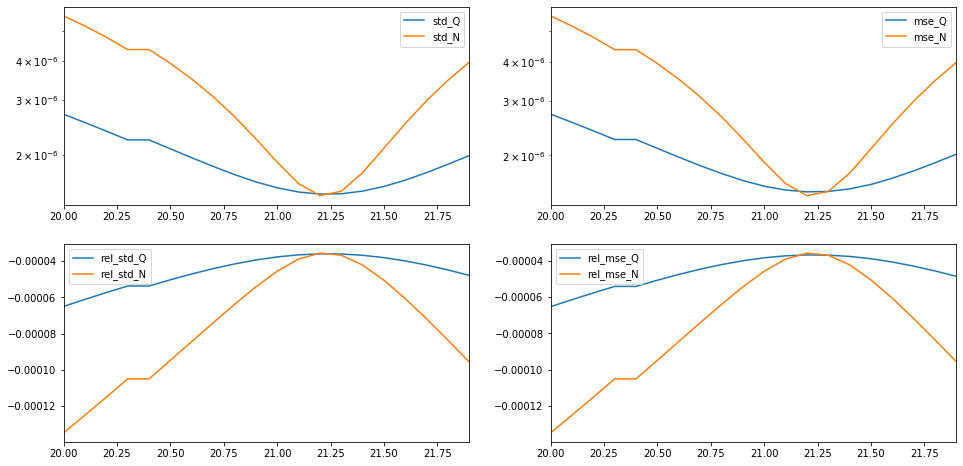

In [154]:
fig, ax=plt.subplots(ncols=2,nrows=2,figsize=(16,8))
reslist.plot(y=["std_Q","std_N"],logy=True,ax=ax[0,0])
reslist.plot(y=["mse_Q","mse_N"],logy=True,ax=ax[0,1])
reslist.plot(y=["rel_std_Q","rel_std_N"],ax=ax[1,0])
reslist.plot(y=["rel_mse_Q","rel_mse_N"],ax=ax[1,1])

x axis hows the delay time of USB and FPGA in ms.  blue shows quiet data and orange noisy.

RMSE errors show:
- the delay times are different for quite and noisy environment  

The standard deviation doesnt overlap with the RMSE, thats because RMSE is not reliabe as offset value matters here. There is a way out, but is not of our interest. Hence, I ignore this problem. 

There is a tiny difference between the timing error in the stadndard deviation.  
This is due to the fact that the two DAQ card has different low pass filters. The imprinted time delay due to the phase delay of the filter on the low frequnecy of the data is shorter than at higher frequncy. Thats why the noise data is further delayed. 

This is the same issue, we aim to address with the MEMS circuits as well.

The key point here is that shifting time around woulnd improve the 0.002 ratio!!!!

# 2. Making things even worse - introducing missing data

As we have seen that shifting data wont make much difference. I will keep the data unshifted and loop through missing data.

The nature of comparison here is slightly different:  
- I want to compare Reference(USB) with complete sensitive function <b>VS.</b> the FPGA data convolved with incomplete sensitivity function.  
- here I want to minimise RMSE


In [165]:
def getNoise_MissingdT(dataQ, dataN, shiftNr, misNr):
    data_shifted = [shiftData(dataset,shiftNr) for dataset in [dataQ, dataN]]
    senFct20=senFct(0.02,10000,0)
    senFct20_mis=senFct(0.02,10000,misNr)
    
    nrDataInter = len(senFct20)
    nrMeasurement = int(len(data_shifted[0])/nrDataInter)
    senFct20Data = np.concatenate([senFct20 for i in range(nrMeasurement)])
    senFct20Data_mis = np.concatenate([senFct20_mis for i in range(nrMeasurement)])
    
    for i in range(2):
        data_shifted[i]["SensFct"]=senFct20Data
        data_shifted[i]["FPGA"]=data_shifted[i]["FPGA"]-(data_shifted[i]["FPGA"][0:5000].mean()-data_shifted[i]["USB"][0:5000].mean())
        data_shifted[i]["SensFct_mis"]=senFct20Data_mis
    
    usbPhase=[[],[]]
    fpgaPhase=[[],[]]
    for ind, dataset in enumerate(data_shifted):
        for i in range(nrMeasurement):
            fpgaPhase[ind].append((dataset["FPGA"]*dataset["SensFct_mis"]).iloc[i*nrDataInter:(i+1)*nrDataInter].mean())
            usbPhase[ind].append((dataset["USB"]*dataset["SensFct"]).iloc[i*nrDataInter:(i+1)*nrDataInter].mean())
    usbPhase=np.array(usbPhase)
    fpgaPhase=np.array(fpgaPhase)
    
    stdsqQ=np.std((usbPhase[0]-fpgaPhase[0]))
    rel_stdsqQ=stdsqQ/(usbPhase[0].mean())
    stdsqN=np.std((usbPhase[1]-fpgaPhase[1]))
    rel_stdsqN=stdsqN/(usbPhase[1].mean())
    
    msesqQ=np.sqrt(np.mean((usbPhase[0]-fpgaPhase[0])**2))
    rel_msesqQ=msesqQ/(usbPhase[0].mean())
    msesqN=np.sqrt(np.mean((usbPhase[1]-fpgaPhase[1])**2))
    rel_msesqN=msesqN/(usbPhase[1].mean())
    
    return [[stdsqQ, rel_stdsqQ, stdsqN, rel_stdsqN ,msesqQ, rel_msesqQ, msesqN, rel_msesqN],[usbPhase, fpgaPhase]]
# the output is [[std],[mse],[phasedata]]
# where [std] and [mse] consist of [quiet, noisy]
# where "quiet" and "noisy" consists of [error, relative error]

In [168]:
dBinlist=np.arange(0,20)
reslist0 = []
reslist1 = []
for dBin in dBinlist:
    temp =getNoise_MissingdT(quietdata,noisydata,int(0.0212*10000),dBin)
    reslist0.append(temp[0])
    reslist1.append(temp[1])
reslist0=pd.DataFrame(reslist0,
                      columns=["std_Q","rel_std_Q","std_N","rel_std_N","mse_Q","rel_mse_Q","mse_N","rel_mse_N"],
                      index=dBinlist/10
                     )

Text(0.5, 0, 'Missing duration [ms]')

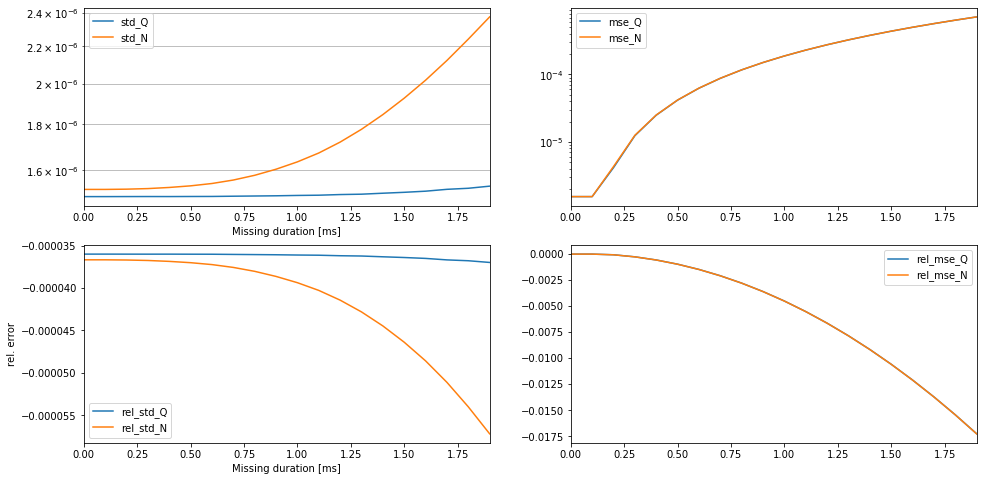

In [170]:
fig, ax=plt.subplots(ncols=2,nrows=2,figsize=(16,8))
reslist0.plot(y=["std_Q","std_N"],logy=True,ax=ax[0,0])
reslist0.plot(y=["mse_Q","mse_N"],logy=True,ax=ax[0,1])
reslist0.plot(y=["rel_std_Q","rel_std_N"],ax=ax[1,0])
reslist0.plot(y=["rel_mse_Q","rel_mse_N"],ax=ax[1,1])
ax[0,0].grid(which="minor")
ax[1,0].grid(which="minor")
ax[0,0].set_xlabel("Missing duration [ms]")
ax[1,0].set_ylabel("rel. error")
ax[1,0].set_xlabel("Missing duration [ms]")

In [171]:
relstdQ=[np.std(reslist1[i][0][0]-reslist1[i][1][0])/np.mean(reslist1[i][0][0]) for i in range(20)]
relmeanQ=[np.mean(reslist1[i][0][0]-reslist1[i][1][0])/np.mean(reslist1[i][0][0]) for i in range(20)]

relstdN=[np.std(reslist1[i][0][1]-reslist1[i][1][1])/np.mean(reslist1[i][0][0]) for i in range(20)]
relmeanN=[np.mean(reslist1[i][0][1]-reslist1[i][1][1])/np.mean(reslist1[i][0][0]) for i in range(20)]

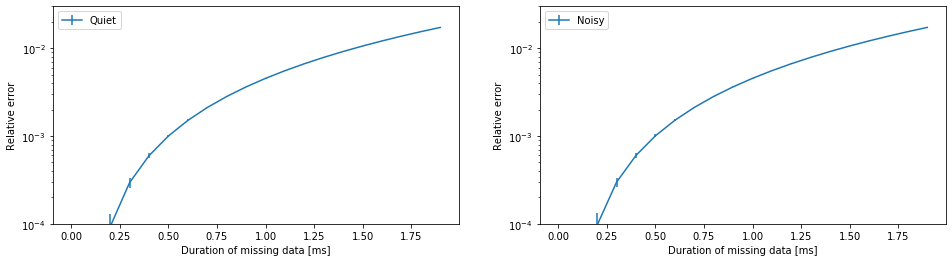

In [172]:
fig, ax=plt.subplots(ncols=2, figsize=(16,4))
ax[0].errorbar(dBinlist/10,relmeanQ, relstdQ)
ax[1].errorbar(dBinlist/10,relmeanN, relstdN)
for i in range(2):
    ax[i].set_yscale("log", nonposy='clip')
    ax[i].set_ylim([0.0001,0.03])
    ax[i].set_xlabel("Duration of missing data [ms]")
    ax[i].set_ylabel("Relative error")
ax[0].legend(["Quiet"])
ax[1].legend(["Noisy"])

In summary, the mean error can be supressed by better offset calibration. However, the error bar in the plot above shows the uncertainty of the error, which wont change much.  
This is pure dependent on the offset noise.

I think, as long as we stay below 800 us, we are good. the offset noise wont contribute by a factor of 2.

In [2]:
!jupyter nbconvert --to pdf --template hidecode FPGA_accuracy_checking-Copy1.ipynb

[NbConvertApp] Converting notebook FPGA_accuracy_checking-Copy1.ipynb to pdf
[NbConvertApp] Support files will be in FPGA_accuracy_checking-Copy1_files\
[NbConvertApp] Making directory .\FPGA_accuracy_checking-Copy1_files
[NbConvertApp] Making directory .\FPGA_accuracy_checking-Copy1_files
[NbConvertApp] Making directory .\FPGA_accuracy_checking-Copy1_files
[NbConvertApp] Making directory .\FPGA_accuracy_checking-Copy1_files
[NbConvertApp] Making directory .\FPGA_accuracy_checking-Copy1_files
[NbConvertApp] Making directory .\FPGA_accuracy_checking-Copy1_files
[NbConvertApp] Making directory .\FPGA_accuracy_checking-Copy1_files
[NbConvertApp] Writing 30903 bytes to .\notebook.tex
[NbConvertApp] Building PDF
Traceback (most recent call last):
  File "C:\Users\X\Anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\Users\X\Anaconda3\lib\site-packages\jupyter_core\application.py", line 267, in launch_instance
    return super(JupyterApp, cls)